### FUTU session

In [2]:
from futu import *

from datetime import datetime
import numpy as np
import pandas as pd
# 获取两个时间之间的分钟数
def get_minutes_interval(begin, end):

    if not isinstance(begin, datetime) or not isinstance(end, datetime):
        raise TypeError('should be datetime')
    if begin > end:
        return 0
    return ((end - begin).total_seconds() / 60).__floor__()
# 获取当日开盘以来已经完成多少分钟k线
def get_bars_from_opening(date_time):

    morning_open = date_time.replace(hour=9, minute=30, second=0, microsecond=0)
    morning_close = date_time.replace(hour=12, minute=0,second=0, microsecond=0)
    afternoon_open = date_time.replace(hour=13, minute=0, second=0, microsecond=0)
    afternoon_close = date_time.replace(hour=16, minute=0, second=0, microsecond=0)
    if date_time < morning_open:
        return 0
    elif date_time < morning_close:
        return get_minutes_interval(morning_open, date_time)
    elif date_time < afternoon_open:
        return get_minutes_interval(morning_open, morning_close)
    elif date_time < afternoon_close:
        return get_minutes_interval(morning_open, morning_close) + get_minutes_interval(afternoon_open, date_time)
    else:
        return get_minutes_interval(morning_open, morning_close) + get_minutes_interval(afternoon_open, afternoon_close)

############################ 全局变量设置 ############################
# mode约定值 realtime：使用实时数据交易 history：历史数据backtest
MODE = 'online'

FUTUOPEND_ADDRESS = '127.0.0.1'  # FutuOpenD 监听地址
FUTUOPEND_PORT = 11111  # FutuOpenD 监听端口

TRADING_ENVIRONMENT = TrdEnv.SIMULATE  # 交易环境：真实 / 模拟
TRADING_MARKET = TrdMarket.HK  # 交易市场权限，用于筛选对应交易市场权限的账户
TRADING_PWD = '123456'  # 交易密码，用于解锁交易
TRADING_PERIOD = KLType.K_1M  # 信号 K 线周期
# TRADING_SECURITY = 'HK.800000'  # 交易标的
TRADING_SECURITY = 'HK.HSIcurrent'  # 交易标的

# QUATE_SECURITY = 'HK.800000'
QUATE_SECURITY = 'HK.HSIcurrent'

quote_context = OpenQuoteContext(host=FUTUOPEND_ADDRESS, port=FUTUOPEND_PORT)  # 行情对象
trade_context = OpenSecTradeContext(filter_trdmarket=TRADING_MARKET, host=FUTUOPEND_ADDRESS, port=FUTUOPEND_PORT, security_firm=SecurityFirm.FUTUSECURITIES)  # 交易对象，根据交易品种修改交易对象类型

# 订阅标的合约的 分时、1分钟k线
def subscribe():
    ret_sub, err_message = quote_context.subscribe(code_list=[QUATE_SECURITY], subtype_list=[SubType.RT_DATA, SubType.K_1M], subscribe_push=False)
    if ret_sub == RET_OK:   # 订阅成功
        print('subscribe successfully！current subscription status :', quote_context.query_subscription())  # 订阅成功后查询订阅状态
    else:
        print('subscription failed', err_message)

# 订阅动作
subscribe()

# 获取实时k线
def cur_kline():
    ret, data = quote_context.get_cur_kline(code=QUATE_SECURITY, num=get_bars_from_opening(datetime.now()) + 3, ktype=TRADING_PERIOD, autype = AuType.QFQ)
    if ret == RET_OK:
        print(data)
    else:
        print('error:', data)
    return data

# 能获取的最大历史数据k线
def history_all_kline():
    all_kls = None
    ret, data, page_req_key = quote_context.request_history_kline(QUATE_SECURITY, ktype=TRADING_PERIOD, autype = AuType.QFQ, start='2018-01-01', end=datetime.now().strftime('%Y-%m-%d'), max_count=330)  #请求第一页
    if ret == RET_OK:
        all_kls = data
    else:
        print('error:', data)
        return
    while page_req_key != None:  # 请求后面的所有结果
        ret, data, page_req_key = quote_context.request_history_kline(QUATE_SECURITY, ktype=TRADING_PERIOD, autype = AuType.QFQ, start='2018-01-01', end=datetime.now().strftime('%Y-%m-%d'), max_count=330, page_req_key=page_req_key) # 请求翻页后的数据
        if ret == RET_OK:
            all_kls = pd.concat([all_kls, data], ignore_index = True)
        else:
            print('error:', data)
            return
    all_kls.to_csv('HSIcurrent_2Y_1M_KLines.csv')
    print('All pages are finished!')

def history_spec_kline(date_str):
    ret, data, page_req_key = quote_context.request_history_kline(QUATE_SECURITY, ktype=TRADING_PERIOD, autype = AuType.QFQ, start=date_str, end=date_str)  #请求第一页
    if ret == RET_OK:
        print(data)
    else:
        print('error:', data)
    return data

ck = cur_kline()
history_all_kline()
# hsk = history_spec_kline('2022-06-14')

print('脚本退出！')
quote_context.close()
trade_context.close()

2022-08-05 14:24:00,701 | 18916 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=8, host=127.0.0.1, port=11111, user_id=17751493
2022-08-05 14:24:00,704 | 18916 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=9, host=127.0.0.1, port=11111, user_id=17751493
subscribe successfully！current subscription status : (0, {'total_used': 2, 'remain': 298, 'own_used': 2, 'sub_list': {'RT_DATA': ['HK.HSIcurrent'], 'K_1M': ['HK.HSIcurrent']}})
              code             time_key     open    close     high      low  \
0    HK.HSIcurrent  2022-08-05 09:28:00  20239.0  20236.0  20242.0  20231.0   
1    HK.HSIcurrent  2022-08-05 09:29:00  20237.0  20227.0  20237.0  20226.0   
2    HK.HSIcurrent  2022-08-05 09:30:00  20227.0  20229.0  20230.0  20223.0   
3    HK.HSIcurrent  2022-08-05 09:31:00  20228.0  20197.0  20243.0  20189.0   
4    HK.HSIcurrent  2022-08-05 09:32:00  20197.0  20210.0  20223.0  20194.0   
..             ...               

### 预定义

In [29]:
# 判断当前bar是否是范围内的最高点
def is_pivot_high(bars , bar_index, left_bars_count, right_bars_count):
    if bar_index - left_bars_count < 0:
        return False
    if bar_index + right_bars_count > len(bars) - 1:
        return False
    current = bars.iloc[bar_index]
    # iloc[index1,index2] index2侧为开区间
    left = bars.iloc[bar_index - left_bars_count : bar_index]['high'] < bars.iloc[bar_index]['high']
    right = bars.iloc[bar_index + 1 : bar_index + right_bars_count + 1]['high'] < bars.iloc[bar_index]['high']
    return left.eq(True).all() and right.eq(True).all()

# 判断当前bar是否是范围内的最低点
def is_pivot_low(bars, bar_index, left_bars_count, right_bars_count):
    if bar_index - left_bars_count < 0:
        return False
    if bar_index + right_bars_count > len(bars) - 1:
        return False
    current = bars.iloc[bar_index]
    # iloc[index1,index2] index2侧为开区间
    left = bars.iloc[bar_index - left_bars_count : bar_index]['low'] > bars.iloc[bar_index]['low']
    right = bars.iloc[bar_index + 1 : bar_index + right_bars_count + 1]['low'] > bars.iloc[bar_index]['low']
    return left.eq(True).all() and right.eq(True).all()

# 返回k线当中的全部高点
def pivot_high(bars, left_bars, right_bars):
    index = []
    for i in range(left_bars, len(bars) - right_bars):
        if is_pivot_high(bars, i, left_bars, right_bars):
            index.append(i)
    return bars.iloc[index]

# 返回k线当中的全部低点
def pivot_low(bars, left_bars, right_bars):
    index = []
    for i in range(left_bars, len(bars) - right_bars):
        if is_pivot_low(bars, i, left_bars, right_bars):
            index.append(i)
    return bars.iloc[index]

# 将k线集合分拆为4个集合，high,low,open,close
def get_bar_keys(bars, left_bars, right_bars):
    return pivot_high(bars, left_bars, right_bars)['high'], pivot_low(bars, left_bars, right_bars)['low'], bars['open'], bars['close']

class Timing:
    def __init__(self, signal = -1, time = datetime.time, price = 0, reason_desc = ''):
        # signal：0做多 1做空
        self.signal = signal
        self.time = time
        self.price = price
        self.reason_desc = reason_desc
    
    def __str__(self):
        return 'signal' + self.signal.__str__() + ', ' + 'time' + self.time.__str__() + ', ' + 'price' + self.price + '\n'

class Trade:
    def __init__(self, enter_timing = None, exit_timing = None, profit = 0, max_drawdown = 0):
        self.enter_timing = enter_timing
        self.exit_timing = exit_timing
        self.profit = profit
        self.max_drawdown = max_drawdown
    
    def __str__(self):
        return 'enter_timing:' + self.enter_timing.__str__() + 'exit_timing:' + self.exit_timing.__str__() + 'profit:' + self.profit

### 历史数据回测

In [30]:
PIVOT_LEFT_BARS_COUNT = 3
PIVOT_RIGHT_BARS_COUNT = 2

# 经历的所有交易
trades = []

def kline_series_mock(klines):
    for index, row in klines.iterrows():
        h_point, highs = get_highs(klines.iloc[:index + 1])
        l_point, lows = get_lows(klines.iloc[:index + 1])
        if not (h_point is None):
            high_diff = highs['high'].diff()
            p_diff_value = high_diff.tail(2).head(1).values[0]
            c_diff_value = high_diff.tail(1).values[0]
            # 左低右高上尖角
            if p_diff_value > 0 and c_diff_value < 0 and abs(p_diff_value) < abs(c_diff_value):
                if trades:
                    trade = trades[-1]
                    enter_timing = trade.enter_timing
                    # 先前是做多
                    if enter_timing.signal == 0:
                        exit_timing = Timing(time = h_point['time_key'].values[0], price = h_point['open'].values[0])
                        trade.exit_timing = exit_timing
                        trade.profit = exit_timing.price - enter_timing.price
                    # 先前是做空，什么都不做
                    else:
                        return
                n_enter_timing = Timing(signal = 1, time = h_point['time_key'].values[0], price = h_point['open'].values[0])
                n_trade = Trade(enter_timing = n_enter_timing)
                trades.append(n_trade)
        if not (l_point is None):
            low_diff = lows['low'].diff()
            p_diff_value = low_diff.tail(2).head(1).values[0]
            c_diff_value = low_diff.tail(1).values[0]
            # 左高右低下尖角
            if p_diff_value > 0 and c_diff_value < 0 and abs(p_diff_value) < abs(c_diff_value):
                if trades:
                    trade = trades[-1]
                    enter_timing = trade.enter_timing
                    # 先前是做空
                    if enter_timing.signal == 1:
                        exit_timing = Timing(time = l_point['time_key'].values[0], price = l_point['open'].values[0])
                        trade.exit_timing = exit_timing
                        trade.profit = exit_timing.price - enter_timing.price
                    # 先前是做多，什么都不做
                    else:
                        return
                n_enter_timing = Timing(signal = 0, time = l_point['time_key'].values[0], price = l_point['open'].values[0])
                n_trade = Trade(enter_timing = n_enter_timing)
                trades.append(n_trade)

def get_highs(c_bars):
    p_bars = c_bars.drop(c_bars.tail(1).index)
    p_high_bars = pivot_high(p_bars, PIVOT_LEFT_BARS_COUNT, PIVOT_RIGHT_BARS_COUNT)
    c_high_bars = pivot_high(c_bars, PIVOT_LEFT_BARS_COUNT, PIVOT_RIGHT_BARS_COUNT)
    if len(c_high_bars) > len(p_high_bars):
        return c_bars.tail(1), c_high_bars
    return None, None

def get_lows(c_bars):
    p_bars = c_bars.drop(c_bars.tail(1).index)
    p_low_bars = pivot_low(p_bars, PIVOT_LEFT_BARS_COUNT, PIVOT_RIGHT_BARS_COUNT)
    c_low_bars = pivot_low(c_bars, PIVOT_LEFT_BARS_COUNT, PIVOT_RIGHT_BARS_COUNT)
    if len(c_low_bars) > len(p_low_bars):
        return c_bars.tail(1), c_low_bars
    return None, None

    
# 待测试的历史数据
    # 新的bar打开，即刚完成了一个bar，回调
    # 获取当日到目前为止已经生成的所有bars
    # 删除最后一个元素得到 p_bars
    # 分别计算high_bars
    # 如果high_bars有增加，再计算h_high_bars
    # 如果h_high_bars也有增加，表明出现了一个上尖角
    # 下尖角逻辑相同


# 查看尖角是哪边高哪边低
    # 找到尖角的


bt_data = hsk
kline_series_mock(bt_data)

In [31]:
for trade in trades:
    print(trade)

TypeError: can only concatenate str (not "int") to str

In [14]:
bt_data['high'].tail(2).head(1).values[0]

21085.66

In [15]:
bt_data['high'].tail(2).head(1)

329    21085.66
Name: high, dtype: float64

In [4]:
# 出场时机
def exit_time():
    if trade is None:
        return False
    enter_timing = trade.enter_timing

    

# k线回调入口
# 该方法为原型算法，正式流程会将此过程拆分为异步处理
def on_bar_open_prototype(current_bar):
    # 更新并获取上下文
        # 高点低点信息
        # 高高点以及同类四类信息
    # 出场
        # 获取当前订单情况
        # 判断是否触发止损，如果触发，出场
        # 计算是否是出场点，如果是出场点，出场
    # 入场
        # 计算是否是入场点
        # 计算仓位和入场金额，入场
        # 计算多/空方止损点，并设置
    pass

def context_refresh():
    pass


# cum_profit：总利润
# run_up：到目前为止一共盈利百分比

def is_enter_time():
    pass


def stop_loss():
    pass



# 入场动作
def enter():
    pass

# 出场动作，返回
def exit():
    pass

### 统计部分

### 绘图部分

<AxesSubplot:>

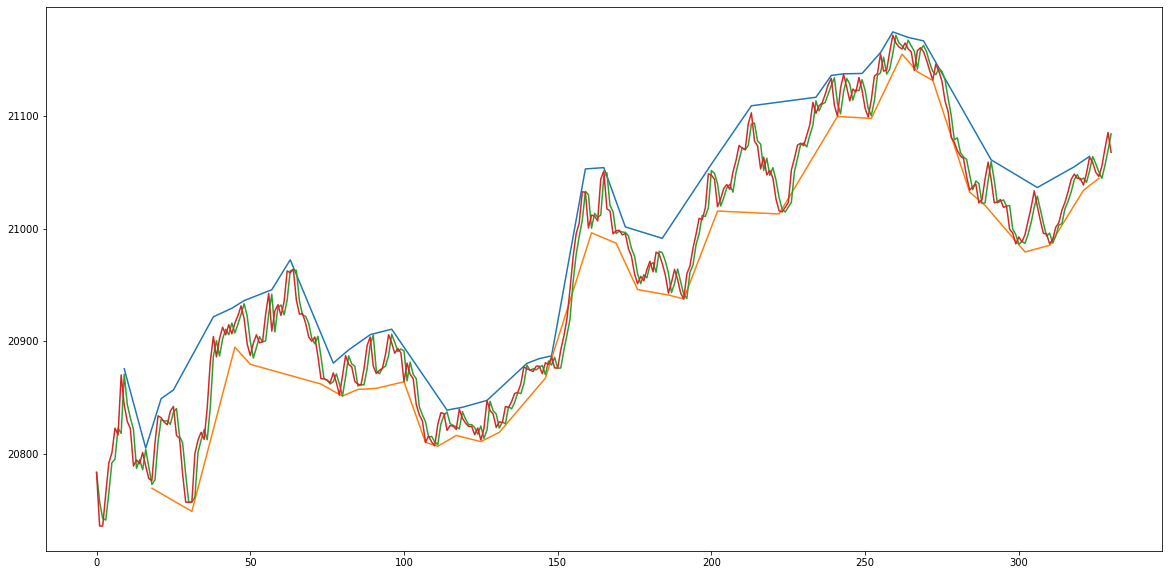

In [5]:
import matplotlib.pyplot as plt
# 待绘图的k线集合，极值点判断区间
bars = hsk


highs, lows, opens, closes  = get_bar_keys(bars, PIVOT_LEFT_BARS_COUNT, PIVOT_RIGHT_BARS_COUNT)
fig, axes = plt.subplots(1,1,figsize=(20,10))
highs.plot(ax = axes)
lows.plot(ax=axes)
opens.plot(ax=axes)
closes.plot(ax=axes)